### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/train/'
VAL_DATASET_PATH = '../data/val/'
TEST_DATASET_PATH = '../data/test/'

### Read augmented images from folder

In [2]:
def read_files(paths):
    rawx=[]
    rawy=[]
    for p in paths:
        for root, dirs, files in os.walk(p):
            for file in files:
                img = cv2.imread(os.path.join(root,file),cv2.IMREAD_GRAYSCALE)
                rawx.append(img)
                rawy.append(int(file.split('_')[1]))
    h, w = rawx[0].shape
    
    xy = list(zip(rawx,rawy))
    random.shuffle(xy)
    rawx,rawy = zip(*xy)
    
    rawx = np.asarray(rawx)
    rawy = np.asarray(rawy)
    rawx = rawx.reshape(len(rawx),h*w)
#     rawx = rawx / 255.
    return rawx, rawy, h, w

In [3]:
xtrain, ytrain, im_h, im_w = read_files([DATASET_PATH,VAL_DATASET_PATH])
num_classes = len(np.unique(ytrain))

In [4]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([1150, 1150, 1150, 1150, 1150, 1150], dtype=int64))

### Read test images from originals_test folder

In [5]:
xtest, ytest, im_h, im_w = read_files([TEST_DATASET_PATH])

### Check how the images looks like

In [6]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

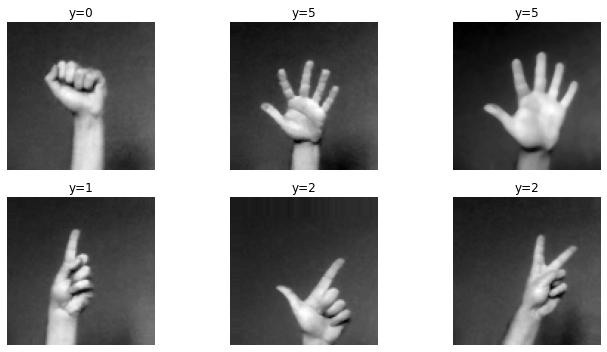

In [7]:
plot_6_images(xtrain,ytrain)

### Images are 100*100, perform PCA to reduce dimension perserving most of the variance

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 3min 33s


In [9]:
print('dimension reduction from %d to %d after PCA preserving 99%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 10000 to 800 after PCA preserving 99% of variance


### Check how the images look like after PCA

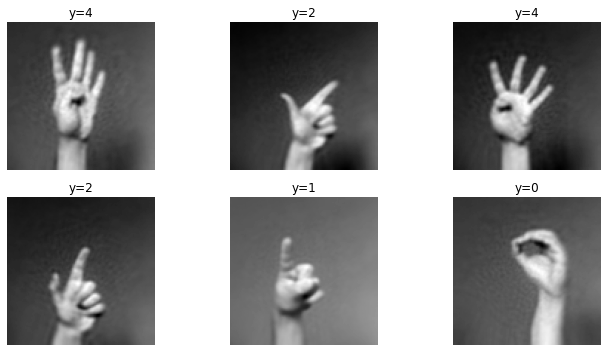

In [10]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

### Train different classifiers using default parameters

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

classifs = [
           SGDClassifier(), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               ]

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())

Wall time: 14.5 s
SGD		 : [0.69478261 0.65956522 0.67608696] Score :  Worst: 0.6596
Wall time: 39.2 s
KNN		 : [0.89086957 0.88869565 0.87782609] Score :  Worst: 0.8778
Wall time: 11.2 s
DecisionTree	 : [0.63173913 0.6273913  0.63043478] Score :  Worst: 0.6274
Wall time: 1min
SVC		 : [0.95478261 0.94782609 0.95521739] Score :  Worst: 0.9478
Wall time: 26.7 s
RandomForest	 : [0.79       0.80434783 0.79304348] Score :  Worst: 0.7900


### SGD is fast and looks promising, finetune it using gridsearch 

In [12]:
from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {
#         'bootstrap':[True,False],
#         'n_estimators':[10,50,100,],
#         'max_features':[5,10,'auto'],
#         'max_depth':[5,10,None],
#     }
# ]

# clf = RandomForestClassifier(random_state=37)

clf = SGDClassifier(random_state=37)

param_grid = [
    {
        'penalty':['l2','elasticnet'],
        'learning_rate':['optimal','adaptive'],
        'eta0':[0.01,0.02]
    }
]

grid_search = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search.fit(X_reduced,ytrain);

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  7.1min finished


Wall time: 7min 23s


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=37,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'eta0': [0.01, 0.02],
                          'learning_rate': ['optimal', 'adaptive'],
                          'penalty': ['l2', 'elasticnet']}],
             pre_dispatch='2*n_job

In [13]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'eta0': 0.01, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
0.6908695652173913


### Check accuracy on test dataset

In [14]:
from sklearn.model_selection import cross_val_predict

Xtest_reduced = pca.transform(xtest)
ytest_pred = cross_val_predict(grid_search.best_estimator_,Xtest_reduced,ytest,cv=3)
score = grid_search.best_estimator_.score(Xtest_reduced, ytest)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 66.50% on test dataset (1200 obs)


### Check confusion matrix

In [15]:
import pandas as pd

pd.crosstab(ytest, ytest_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,164,24,1,6,2,3,200
1,33,106,26,8,12,15,200
2,6,15,152,18,3,6,200
3,6,10,25,134,15,10,200
4,12,6,12,7,146,17,200
5,5,1,5,7,12,170,200
All,226,162,221,180,190,221,1200


### Showing on a graph only differences (relative values) 

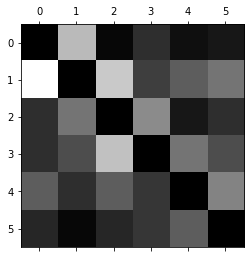

In [16]:
from sklearn.metrics import confusion_matrix

confmatr = confusion_matrix(ytest, ytest_pred)
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Save model. (PCA has to be saved also to apply same transformation for future predictions)

In [17]:
import pickle

filename = '../models/model_classic.sav'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

filename = '../models/model_classic_pca.sav'
pickle.dump(pca, open(filename, 'wb'))

### Try our model on a never seen before picture (original one)

In [18]:
# import pickle
# import os
# import random
# import cv2
# import matplotlib.pyplot as plt
# im_h,im_w=100,100
# filename = '../models/model_classic.sav'
# loaded_model = pickle.load(open(filename, 'rb'))

# filename = '../models/model_classic_pca.sav'
# loaded_pca = pickle.load(open(filename, 'rb'))

In [19]:
# pick one random from xtest
# idx = random.randint(0,len(xtest)-1)

# myimg = xtest[idx]
# myimg = cv2.resize(myimg,(im_h, im_w))
# myimg = myimg.reshape(1,im_h* im_w)

# xpca = loaded_pca.transform(myimg)

# result = loaded_model.predict(xpca)
# pred = result[0]

# plt.imshow(xtest[idx].reshape(im_w,im_h), cmap='gray');
# plt.title('y=%d' % pred);
# plt.axis('off');

In [20]:
def plot_6_images_test(xt,yt,yp):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        if yt[idxs[i]]==yp[idxs[i]]:
          c = 'green'
        else:
          c = 'red'
        plt.title('y=%d / pred=%d' % (yt[idxs[i]],yp[idxs[i]]),color=c)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

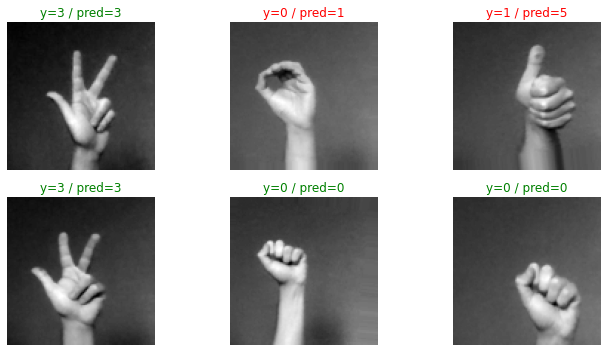

In [21]:
plot_6_images_test(xtest,ytest,ytest_pred)